In [19]:
from keras.engine import *
from keras.engine.topology import Container
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.losses import *
from keras.optimizers import *
import numpy as np
import keras.backend as K
from functools import reduce
from tqdm import tqdm_notebook
from keras.utils.np_utils import to_categorical
from matplotlib import pylab as plt
from IPython.display import clear_output
from prefetch_generator import BackgroundGenerator
import pickle
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [20]:
TEXT_LENGTH = 140

In [21]:
with open("./parsed.txt", "r") as f:
    texts = f.read().split("\n")
tokenizer = Tokenizer(filters="\n", lower=False)

In [22]:
tokenizer.fit_on_texts(texts)
VOCAB = len(tokenizer.word_index)
X = tokenizer.texts_to_sequences(texts)

In [5]:
class InvTokenizer:
    def __init__(self, dic):
        self.dic = dic
        self.num = len(dic)
        self.invdec = ["" for _ in range(self.num + 1)]
        for c, i in self.dic.items():
            self.invdec[i] = c
    
    def __call__(self, array):
        if len(array) == 0: return("")
        return(reduce(lambda x,y:x+y,[self.invdec[int(i)] for i in list(array)]))
            
texgen = InvTokenizer(tokenizer.word_index)

In [6]:
def myloss(y_true, y_pred):
    elems = (y_true, y_pred)
#     acc = K.map_fn(lambda x:K.sparse_categorical_crossentropy(x[1], x[0]), elems)
    print(elems)
    acc = K.sparse_categorical_crossentropy(y_true, y_pred)
    return(K.mean(acc))
    
def get_model():
    inputs = Input(shape=(None,))
    y = inputs
    y = Embedding(VOCAB+1, 512, mask_zero=True)(y)
    y = Dropout(0.1)(y)
    y = GRU(512, return_sequences=True, recurrent_dropout=0.2)(y)
    y = Dropout(0.1)(y)
    y = GRU(512, return_sequences=True, recurrent_dropout=0.2)(y)
    y = TimeDistributed(Dense(VOCAB+1, activation="softmax", use_bias=False))(y)
    model = Model(inputs, y)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=RMSprop(1e-3))
    return(model)

def datagen(X, batch_size=128):
    x, y = [], []
    np.random.shuffle(X)
    for text in tqdm_notebook(X):
        x.append(text[:-1])
        y.append(text[1:])
        if len(y) >= batch_size:
            x = pad_sequences(np.array(x), maxlen=TEXT_LENGTH, padding="post")
            y = pad_sequences(y, maxlen=TEXT_LENGTH, padding="post")
            y = np.expand_dims(np.array(y), -1)
            yield(x, y)
            x, y = [], []

def get_text(mod):
    x = [[tokenizer.word_index["@SOS"]]]
    while len(x[0]) < 50:
        y = mod.predict(np.array(x))[0][-1]
        y = np.random.choice(VOCAB+1, p=y)
        if y == 1:
            return(texgen(x[0][1:]))
        x[0].append(y)
    return(texgen(x[0][1:]))

In [7]:
mod = get_model()
history = []

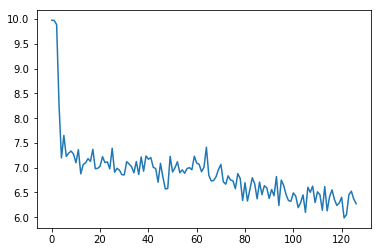

andでしょさせ泊まっ飯買う館陸　highありがとう


KeyboardInterrupt: 

In [12]:
epoch = 100
batch_size = 160
mod.optimizer = RMSprop(1e-3)
for e in range(epoch):
    gen = datagen(X, batch_size=batch_size)
    text = get_text(mod)
    for x, y in BackgroundGenerator(gen):
        loss = mod.train_on_batch(x, y)
        history.append(loss)
        clear_output()
        plt.plot(history)
        plt.show()
        print(text)
mod.save(filepath="./auto_twitter_2.h5", overwrite=True)

In [ ]:
print("\n".join([get_text(mod) for _ in range(50)]))

In [ ]:
mod.predict_on_batch(np.array([[2]])).argsort()[::-1]

In [ ]:
texgen.invdec[3]

In [ ]:
tokenizer.word_index

In [ ]:
next(gen)[1].shape

In [ ]:
tokenizer.word_index["@SOS"]

In [23]:
np.argmax([len(x) for x in texts])

8838

In [24]:
texts[8838]

'@SOS 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け 🐹 へ け EOS'